# [예측모델] 

## - ARIMA 
## - Seasonal ARIMA (SARIMA)
## - Prophet

### 1. 모듈 불러오기

In [ ]:
# !git clone https://github.com/Jiyoon52/LG_time_series_day02_dataset.git

In [5]:
# !pip install pmdarima
# !pip install yfinance
# !pip install prophet

'''로컬 사용시 추가 '''
# !conda install numpy cython -c conda-forge
# !conda install matplotlib scipy pandas -c conda-forge
# !conda install pystan -c conda-forge
# !conda install -c anaconda ephem
# !conda install -c conda-forge prophet
# !pip install pandas_datareader

import os

import numpy as np
import pandas as pd
import pandas_datareader.data as pdr

import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima.arima import auto_arima

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import seaborn as sns
import itertools

#sns.set_style("white")
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 

import yfinance as yfin
from prophet import Prophet

### 2. 데이터 불러오기

In [6]:
data = pd.read_csv('data/AirPassengers.csv')
# data = pd.read_csv('/content/LG_time_series_day02_dataset/data/AirPassengers.csv')
data = data.rename(columns={'Month': 'month', '#Passengers': 'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


### 3. Box-Jenkins ARIMA Procedure
-  3.1 Data Preprocessing
-  3.2 Identify Model to be Tentatively Entertainted
-  3.3 Estimate Parameters
-  3.4 Diagnosis Check
-  3.5 use Model to Forecast

#### 3.1 Data Preprocessing

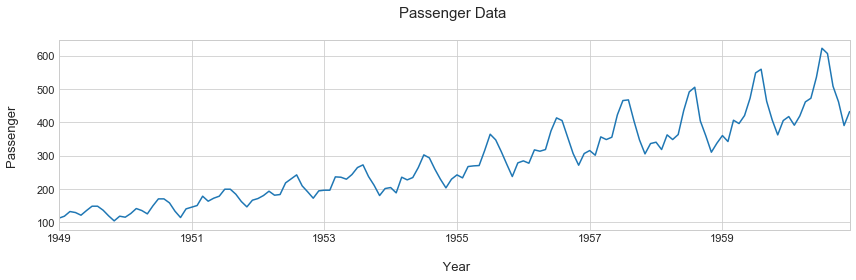

In [7]:
'''
데이터 시각화를 통해 전체 개요 확인
'''
data.plot(figsize=(12,4)) # color='green', linestyle='--', linewidth=1

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend('')

plt.title('Passenger Data \n', fontsize=15)
plt.xlabel('\n Year', fontsize=13)
plt.ylabel('Passenger \n', fontsize=13)
plt.tight_layout()
plt.show()

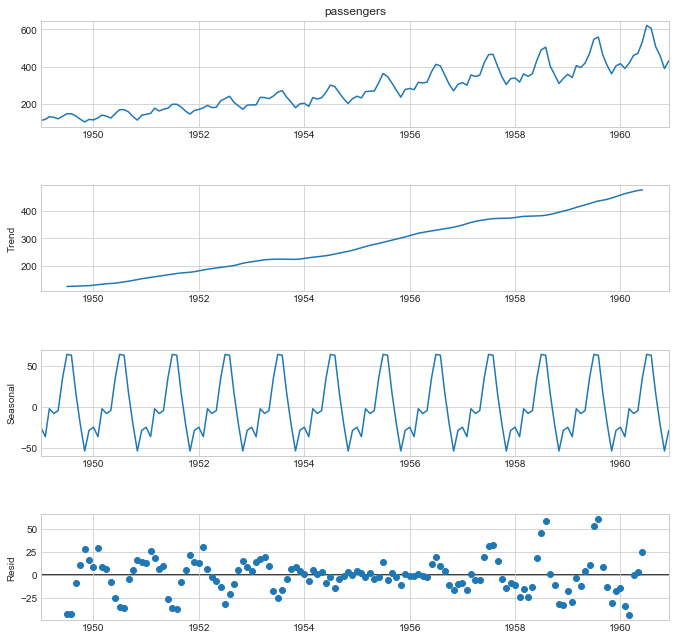

In [8]:
# Seasonal decomposition plot: Seasonal decomposition using moving averages.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

# Observed: observed data
# Trend: The estimated trend component
# Seasonal: The estimated seasonal component
# resid: The estimated residuals

decomposition = sm.tsa.seasonal_decompose(data['passengers'],  model='additive')

fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

#### 3.2 Identify Model to be Tentatively Entertainted

In [9]:
# Train:Test = 8:2
train, test = train_test_split(data, test_size=0.2, shuffle=False)

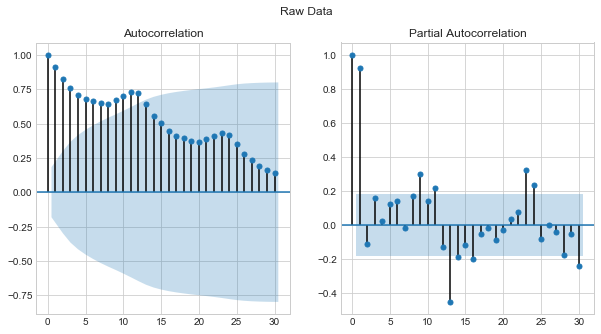

In [10]:
# ACF, PACF plot 

# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=30, ax=ax[1]); # Modify not to generate graph twice

In [11]:
# Differencing

diff_train = train.copy()
diff_train = diff_train['passengers'].diff()
diff_train = diff_train.dropna()
print('####### Raw Data #######')
print(train)
print('### Differenced Data ###')
print(diff_train)

####### Raw Data #######
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
### Differenced Data ###
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


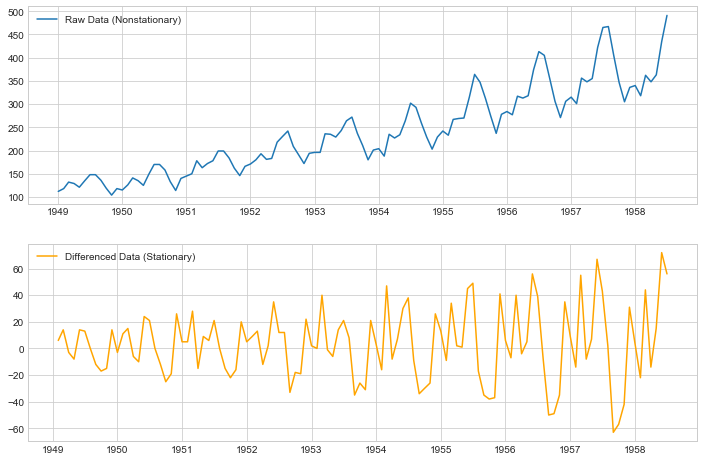

In [12]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train['passengers'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train,'orange') # first difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

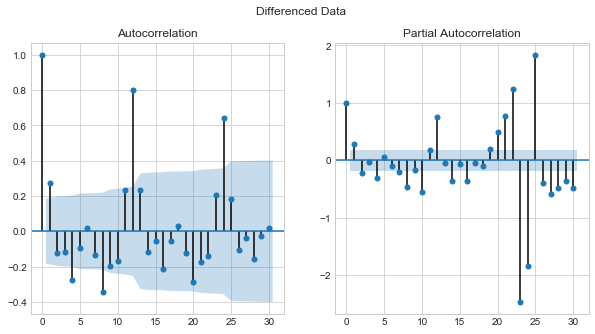

In [13]:
# ACF, PACF plot 

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train.values.squeeze(), lags=30, ax=ax[1]); # Modify not to generate graph twice

#### 3.3 Estimate Parameters

In [15]:
# ARIMA model fitting
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

ARIMA = sm.tsa.arima.ARIMA

ARIMA_model = ARIMA(train.values, order=(1,1,0))
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -532.268
Date:                Wed, 12 Jan 2022   AIC                           1068.536
Time:                        20:16:41   BIC                           1074.008
Sample:                             0   HQIC                          1070.757
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2904      0.089      3.278      0.001       0.117       0.464
sigma2       664.7320     89.253      7.448      0.000     489.800     839.664
===================================================================================
Ljung-Box (Q):                      269.62   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.00   Prob(JB):                         0.20
Heteroskedasticity (H):               6.18   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 3.4.1 Diagnosis Check - ARIMA

In [25]:
# Parameter search 

print('Examples of parameter combinations for ARIMA...')
p = range(0, 4)
d = range(1, 3)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))

aic=[]
for i in pdq:
    model = ARIMA(train.values, order=(i))
    ARIMA_model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(ARIMA_model_fit.aic,2)}')
    aic.append(round(ARIMA_model_fit.aic,2))

Examples of parameter combinations for ARIMA...
ARIMA: (0, 1, 0) >> AIC : 1076.27
ARIMA: (0, 1, 1) >> AIC : 1063.65
ARIMA: (0, 1, 2) >> AIC : 1060.69
ARIMA: (0, 1, 3) >> AIC : 1062.47
ARIMA: (0, 2, 0) >> AIC : 1105.71
ARIMA: (0, 2, 1) >> AIC : 1072.85
ARIMA: (0, 2, 2) >> AIC : 1060.35
ARIMA: (0, 2, 3) >> AIC : 1057.37
ARIMA: (1, 1, 0) >> AIC : 1068.54
ARIMA: (1, 1, 1) >> AIC : 1058.25
ARIMA: (1, 1, 2) >> AIC : 1057.33
ARIMA: (1, 1, 3) >> AIC : 1058.95
ARIMA: (1, 2, 0) >> AIC : 1101.1
ARIMA: (1, 2, 1) >> AIC : 1065.18
ARIMA: (1, 2, 2) >> AIC : 1054.89
ARIMA: (1, 2, 3) >> AIC : 1056.06
ARIMA: (2, 1, 0) >> AIC : 1065.64
ARIMA: (2, 1, 1) >> AIC : 1058.65
ARIMA: (2, 1, 2) >> AIC : 1057.52
ARIMA: (2, 1, 3) >> AIC : 1056.58
ARIMA: (2, 2, 0) >> AIC : 1089.69
ARIMA: (2, 2, 1) >> AIC : 1062.39
ARIMA: (2, 2, 2) >> AIC : 1056.17
ARIMA: (2, 2, 3) >> AIC : 1058.06
ARIMA: (3, 1, 0) >> AIC : 1067.59
ARIMA: (3, 1, 1) >> AIC : 1061.03
ARIMA: (3, 1, 2) >> AIC : 1053.34
ARIMA: (3, 1, 3) >> AIC : 1028.86
A

In [26]:
# Search optimal parameters

ARIMA_optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
ARIMA_optimal

[((3, 1, 3), 1028.86)]

In [74]:
ARIMA_model_opt = ARIMA(train.values, order=ARIMA_optimal[0][0])
ARIMA_model_opt_fit = ARIMA_model_opt.fit()

ARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -507.430
Date:                Wed, 12 Jan 2022   AIC                           1028.861
Time:                        21:08:00   BIC                           1048.014
Sample:                             0   HQIC                          1036.634
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9585      0.095     10.077      0.000       0.772       1.145
ar.L2          0.2874      0.140      2.048      0.041       0.012       0.562
ar.L3         -0.6639      0.091     -7.306      0.000      -0.842      -0.486
ma.L1         -0.8932     64.953     -0.014      0.989    -128.198     126.412
ma.L2         -0.8949    122.834     -0.007      0.994    -241.645     239.855
ma.L3          0.9983     64.699      0.015      0.988    -125.809     127.805
sigma2       392.2837   2.54e+04      0.015      0.988   -4.94e+04    5.02e+04
===================================================================================
Ljung-Box (Q):                      238.27   Jarque-Bera (JB):                 2.51
Prob(Q):                              0.00   Prob(JB):                         0.29
Heteroskedasticity (H):               5.08   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 3.5.1 use Model to Forecast - ARIMA

In [75]:
ARIMA_prediction = ARIMA_model_opt_fit.forecast(len(test))
ARIMA_test_pred = ARIMA_prediction
forecast = ARIMA_model_opt_fit.get_forecast(steps = len(test))
forecasts_and_intervals = forecast.summary_frame()
forecasts_and_intervals

ARIMA_test_ub = forecasts_and_intervals['mean_ci_upper']
ARIMA_test_lb = forecasts_and_intervals['mean_ci_lower']
predict_index = list(test.index)
r2 = r2_score(test, ARIMA_test_pred)

# ARIMA_prediction = ARIMA_model_opt_fit.forecast(len(test))
# ARIMA_test_pred = ARIMA_prediction[0]
# ARIMA_test_ub = ARIMA_prediction[2][:,0]
# ARIMA_test_lb = ARIMA_prediction[2][:,1]
# predict_index = list(test.index)
# r2 = r2_score(test, ARIMA_test_pred)

In [76]:
'''
Quantitative Evaluation
'''
print('ARIMA')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')

ARIMA
------------------------------
MSE: 5261.91
RMSE: 72.54
MAE: 56.33
R2 score: 0.14


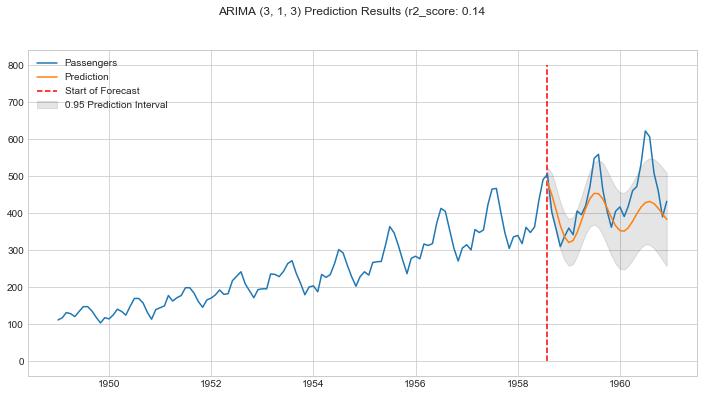

In [77]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('1958-08-01','%Y-%m-%d'), 0, 800, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, ARIMA_test_pred, label = 'Prediction')
ax.fill_between(predict_index, ARIMA_test_lb, ARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {ARIMA_optimal[0][0]} Prediction Results (r2_score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')
plt.show()

#### 3.4.2 Diagnosis Check - SARIMA

In [31]:
# Parameter search 

print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

aic=[]
params=[]
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train.values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))  
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 757.83
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 756.99
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 758.83
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 756.96
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 758.92
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 754.42
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 758.87
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 760.73
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 754.91
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 756.01
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 756.38
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 757.65
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 756.17
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 758.11
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 751.73
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 757.99
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 753.78
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 757.78
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 758.04
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : 759.28
SAR

In [32]:
# Search optimal parameters
SARIMA_optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
SARIMA_optimal

[(((1, 1, 0), (1, 1, 2, 12)), 751.15)]

In [33]:
SARIMA_model_opt = SARIMAX(train.values, order=SARIMA_optimal[0][0][0], seasonal_order = SARIMA_optimal[0][0][1])
SARIMA_model_opt_fit = SARIMA_model_opt.fit()

SARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -370.575
Date:                                 Wed, 12 Jan 2022   AIC                            751.149
Time:                                         20:34:51   BIC                            764.274
Sample:                                              0   HQIC                           756.464
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2364      0.093     -2.554      0.011      -0.418      -0.055
ar.S.L12       0.9982      0.190      5.256      0.000       0.626       1.370
ma.S.L12      -1.3645      2.172     -0.628      0.530      -5.622       2.893
ma.S.L24       0.3916      0.761      0.515      0.607      -1.099       1.883
sigma2        70.1240    139.869      0.501      0.616    -204.014     344.262
===================================================================================
Ljung-Box (Q):                       39.86   Jarque-Bera (JB):                 2.76
Prob(Q):                              0.48   Prob(JB):                         0.25
Heteroskedasticity (H):               1.09   Skew:                             0.38
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 3.5.2 use Model to Forecast - SARIMA

In [78]:
SARIMA_prediction = SARIMA_model_opt_fit.get_forecast(len(test))
SARIMA_test_pred = SARIMA_prediction.predicted_mean
SARIMA_test_ub = SARIMA_prediction.conf_int()[:,0]
SARIMA_test_lb = SARIMA_prediction.conf_int()[:,1]
predict_index = list(test.index)

In [79]:
'''
Quantitative Evaluation
'''
print('SARIMA')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, SARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SARIMA_test_pred), 2)}')

SARIMA
------------------------------
MSE: 676.4
RMSE: 26.01
MAE: 21.45
R2 score: 0.89


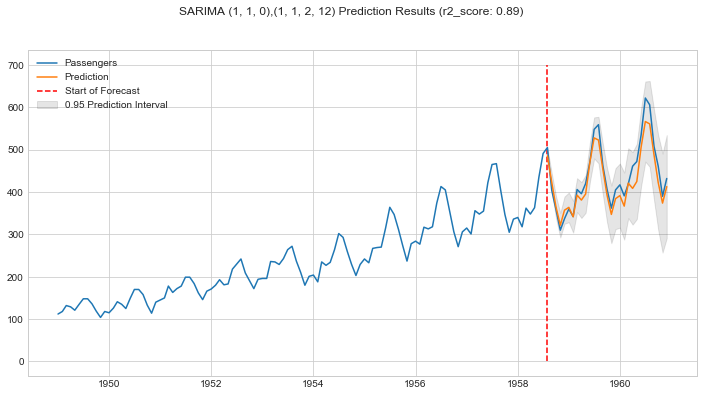

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('1958-08-01','%Y-%m-%d'), 0, 700, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, SARIMA_test_pred, label = 'Prediction')
ax.fill_between(predict_index, SARIMA_test_lb, SARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {SARIMA_optimal[0][0][0]},{SARIMA_optimal[0][0][1]} Prediction Results (r2_score: {np.round(r2_score(test, SARIMA_test_pred), 2)})')
plt.show()

#### 3.4.3 Diagnosis Check - auto_arima

In [90]:
# Parameter search 

auto_arima_model = auto_arima(train, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12, seasonal=True,
                              d=1, D=1, 
                              max_P=3, max_Q=3,
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.08 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.33 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.45 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=1.47 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.47 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=2.14 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.31 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=2.93 sec
 ARIMA(0,1,1)(0,1,0)[1

In [91]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Wed, 12 Jan 2022   AIC                            752.557
Time:                                            21:13:48   BIC                            768.307
Sample:                                                 0   HQIC                           758.934
                                                    - 115                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.657     112.421
===================================================================================
Ljung-Box (Q):                       40.92   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.43   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 3.5.3 use Model to Forecast - auto_arima

In [92]:
AUTO_ARIMA_prediction = auto_arima_model.predict(len(test), return_conf_int=True)
AUTO_ARIMA_test_pred = AUTO_ARIMA_prediction[0]
AUTO_ARIMA_test_ub = AUTO_ARIMA_prediction[1][:,0]
AUTO_ARIMA_test_lb = AUTO_ARIMA_prediction[1][:,1]
predict_index = list(test.index)

In [93]:
'''
Quantitative Evaluation
'''
print('AUTO ARIMA')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, AUTO_ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,AUTO_ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, AUTO_ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, AUTO_ARIMA_test_pred), 2)}')

AUTO ARIMA
------------------------------
MSE: 710.43
RMSE: 26.65
MAE: 22.16
R2 score: 0.88


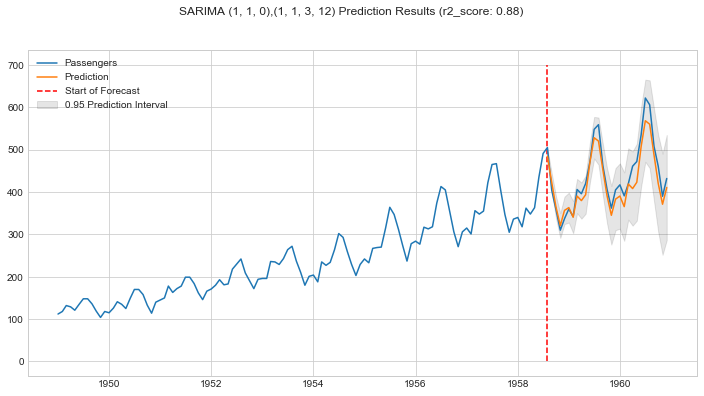

In [94]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('1958-08-01','%Y-%m-%d'), 0, 700, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, AUTO_ARIMA_test_pred, label = 'Prediction')
ax.fill_between(predict_index, AUTO_ARIMA_test_lb, AUTO_ARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order},{auto_arima_model.seasonal_order} Prediction Results (r2_score: {np.round(r2_score(test, AUTO_ARIMA_test_pred), 2)})')
plt.show()

### 4. Prophet

In [95]:
train_prophet = train.reset_index()
train_prophet

,month,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
110,1958-03-01,362
111,1958-04-01,348
112,1958-05-01,363
113,1958-06-01,435


In [96]:
train_prophet.columns = ['ds', 'y']
train_prophet

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
110,1958-03-01,362
111,1958-04-01,348
112,1958-05-01,363
113,1958-06-01,435


In [97]:
PRO_model = Prophet()
PRO_model.fit(train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [98]:
test_prophet = test.reset_index()
test_prophet.columns = ['ds', 'y']
test_data_index = test_prophet[['ds']]
test_data_index

,ds
0,1958-08-01
1,1958-09-01
2,1958-10-01
3,1958-11-01
4,1958-12-01
5,1959-01-01
6,1959-02-01
7,1959-03-01
8,1959-04-01
9,1959-05-01


In [99]:
PRO_prediction = PRO_model.predict(test_data_index)
PRO_prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1958-08-01,401.287591,425.936070,469.847355,401.287295,401.287837,47.322964,47.322964,47.322964,47.322964,47.322964,47.322964,0.0,0.0,0.0,448.610554
1,1958-09-01,404.442971,395.184777,441.881642,404.421452,404.464736,14.293761,14.293761,14.293761,14.293761,14.293761,14.293761,0.0,0.0,0.0,418.736732
2,1958-10-01,407.496565,366.230672,408.627667,407.435923,407.563729,-19.396026,-19.396026,-19.396026,-19.396026,-19.396026,-19.396026,0.0,0.0,0.0,388.100539
3,1958-11-01,410.651945,340.200293,383.055436,410.536162,410.766824,-48.742319,-48.742319,-48.742319,-48.742319,-48.742319,-48.742319,0.0,0.0,0.0,361.909626
4,1958-12-01,413.705539,367.688232,410.272049,413.523106,413.871920,-24.912645,-24.912645,-24.912645,-24.912645,-24.912645,-24.912645,0.0,0.0,0.0,388.792894
5,1959-01-01,416.860919,373.982136,418.792074,416.598460,417.090529,-21.102487,-21.102487,-21.102487,-21.102487,-21.102487,-21.102487,0.0,0.0,0.0,395.758432
6,1959-02-01,420.016300,371.705321,417.761134,419.685009,420.304227,-26.146012,-26.146012,-26.146012,-26.146012,-26.146012,-26.146012,0.0,0.0,0.0,393.870288
7,1959-03-01,422.866321,403.441185,447.921681,422.470289,423.224683,2.043584,2.043584,2.043584,2.043584,2.043584,2.043584,0.0,0.0,0.0,424.909905
8,1959-04-01,426.021701,397.461348,440.824029,425.527138,426.463206,-6.319486,-6.319486,-6.319486,-6.319486,-6.319486,-6.319486,0.0,0.0,0.0,419.702215
9,1959-05-01,429.075295,401.527115,446.287952,428.487915,429.625958,-3.759506,-3.759506,-3.759506,-3.759506,-3.759506,-3.759506,0.0,0.0,0.0,425.315789


In [100]:
PRO_test_pred = PRO_prediction['yhat'].values
PRO_test_ub = PRO_prediction['yhat_upper'].values
PRO_test_lb = PRO_prediction['yhat_lower'].values
predict_index = list(test.index)

In [101]:
'''
Quantitative Evaluation
'''
print('Prophet')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, PRO_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,PRO_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, PRO_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, PRO_test_pred), 2)}')

Prophet
------------------------------
MSE: 1709.49
RMSE: 41.35
MAE: 34.0
R2 score: 0.72


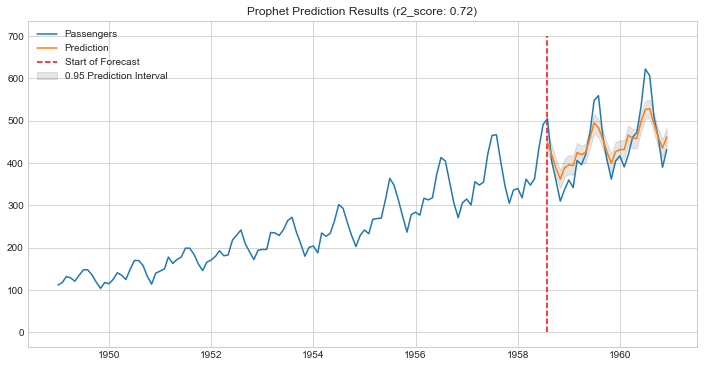

In [102]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('1958-08-01','%Y-%m-%d'), 0, 700, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, PRO_test_pred, label = 'Prediction')
ax.fill_between(predict_index, PRO_test_lb, PRO_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.title(f'Prophet Prediction Results (r2_score: {np.round(r2_score(test, PRO_test_pred), 2)})')
plt.show()

In [103]:
'''
Moving Average
'''
MA_train_pred = train.rolling(5).mean() # Option: min_periods=1
MA_train_pred.columns = ['MA_5']
MA_test_pred = pd.DataFrame(np.array([MA_train_pred.iloc[-1]]*len(test)), index=test.index, columns=['MA_5'])

'''
Simple Eponential Smoothing
'''
L_0 = np.mean(train)  # initial value

SES_train = train.copy()
SES_train = pd.concat([pd.DataFrame(np.zeros(1), columns=['passengers']), SES_train])
SES_train['Level'] = np.nan
SES_train['Forecast'] = np.nan
SES_train.loc[0,'Level'] = L_0.values

SES_train_pred_09 = pd.concat([pd.DataFrame([L_0], columns=['passengers']), train]).ewm(alpha=0.9, adjust=False).mean().iloc[1:]
SES_train_pred_09.columns = ['SES_09']
SES_test_pred_09 = pd.DataFrame(np.array([SES_train_pred_09.iloc[-1]]*len(test)),
                                index=test.index, columns=['SES_09'])

'''
Double Eponential Smoothing
'''
train_reg = train.reset_index()
x = np.array(train_reg.index)
y = train_reg['passengers']

x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()

print(results.summary())
L_0, B_0 = results.params

DES_train = train.copy()
DES_train = pd.concat([pd.DataFrame(np.zeros(1), columns=['passengers']), DES_train])
DES_train['Level'] = np.nan
DES_train['Trend'] = np.nan
DES_train['Forecast'] = np.nan

DES_train.loc[0,'Level'] = L_0
DES_train.loc[0,'Trend'] = B_0

def Double_Exponential_Smoothing(table, alpha, beta):
    # table = DES_train.copy()
    # alpha = 0.16
    # beta = 0.1
    for i in range(len(table)):
        if i == 0: # Skip initialization point
            continue

        x = table.loc[list(table.index)[i],'passengers']
        L_prev = table.loc[list(table.index)[i-1],'Level']
        T_prev = table.loc[list(table.index)[i-1],'Trend']
        
        table.loc[list(table.index)[i],'Level'] = alpha*x + (1-alpha)*(L_prev+T_prev)
        table.loc[list(table.index)[i],'Trend'] = beta*(table.loc[list(table.index)[i],'Level']-L_prev) + (1-beta)*(T_prev)

        L_Pred = table.iloc[-1,1]
        T_Pred = table.iloc[-1,2]
        
        DES_test_pred = L_Pred + range(len(test))*T_Pred
        DES_test_pred = pd.DataFrame(DES_test_pred, index = test.index, columns=['DES'])
        
    return table, DES_test_pred

DES_train_pred, DES_test_pred = Double_Exponential_Smoothing(DES_train, 0.1, 0.1)

'''
Additive Holt-winter
'''

HW_add_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit(optimized=True)
HW_add_train_pred = HW_add_model.fittedvalues
HW_add_test_pred = HW_add_model.forecast(len(test))
HW_add_test_pred = pd.DataFrame(HW_add_test_pred, index=test.index, columns=['HW_add'])


'''
Multiplicative Holt-winter
'''
HW_mul_model = ExponentialSmoothing(train, trend='mul', seasonal='mul').fit(optimized=True)
HW_mul_train_pred = HW_mul_model.fittedvalues
HW_mul_test_pred = HW_mul_model.forecast(len(test))
HW_mul_test_pred = pd.DataFrame(HW_mul_test_pred, index=test.index, columns=['HW_mul'])


                            OLS Regression Results                            
Dep. Variable:             passengers   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     600.9
Date:                Wed, 12 Jan 2022   Prob (F-statistic):           4.79e-47
Time:                        21:13:51   Log-Likelihood:                -575.87
No. Observations:                 115   AIC:                             1156.
Df Residuals:                     113   BIC:                             1161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.6742      6.764     14.293      0.0

In [104]:
'''
Quantitative Evaluation
'''
print('-'*55)
print('Moving Average (N = 5)')
print(f'MSE: {np.round(mean_squared_error(test, MA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,MA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, MA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, MA_test_pred), 2)}')

print('-'*55)
print('Simple Exponential Smoothing (alpha = 0.9)')
print(f'MSE: {np.round(mean_squared_error(test, SES_test_pred_09), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SES_test_pred_09)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_pred_09), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_pred_09), 2)}')

print('-'*55)
print('Double Exponential Smoothing (alpha = 0.16, beta = 0.1)')
print(f'MSE: {np.round(mean_squared_error(test, DES_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,DES_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, DES_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, DES_test_pred), 2)}')

print('-'*55)
print('Additive Holt-Winter Exponential Smoothing')
print(f'MSE: {np.round(mean_squared_error(test, HW_add_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,HW_add_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_add_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_add_test_pred), 2)}')

print('-'*55)
print('Multiplicative Holt-Winter Exponential Smoothing')
print(f'MSE: {np.round(mean_squared_error(test, HW_mul_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,HW_mul_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_mul_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_mul_test_pred), 2)}')

print('-'*55)
print(f'ARIMA {ARIMA_optimal[0][0]}')
print(f'MSE: {np.round(mean_squared_error(test, ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')

print('-'*55)
print(f'SARIMA {SARIMA_optimal[0][0][0]},{SARIMA_optimal[0][0][1]}')
print(f'MSE: {np.round(mean_squared_error(test, SARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SARIMA_test_pred), 2)}')

print('-'*55)
print('Prophet')
print(f'MSE: {np.round(mean_squared_error(test, PRO_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,PRO_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, PRO_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, PRO_test_pred), 2)}')

-------------------------------------------------------
Moving Average (N = 5)
MSE: 7745.58
RMSE: 88.01
MAE: 64.73
R2 score: -0.27
-------------------------------------------------------
Simple Exponential Smoothing (alpha = 0.9)
MSE: 8071.91
RMSE: 89.84
MAE: 78.17
R2 score: -0.32
-------------------------------------------------------
Double Exponential Smoothing (alpha = 0.16, beta = 0.1)
MSE: 4988.28
RMSE: 70.63
MAE: 57.25
R2 score: 0.18
-------------------------------------------------------
Additive Holt-Winter Exponential Smoothing
MSE: 1871.57
RMSE: 43.26
MAE: 35.93
R2 score: 0.69
-------------------------------------------------------
Multiplicative Holt-Winter Exponential Smoothing
MSE: 178.98
RMSE: 13.38
MAE: 11.09
R2 score: 0.97
-------------------------------------------------------
ARIMA (3, 1, 3)
MSE: 5261.91
RMSE: 72.54
MAE: 56.33
R2 score: 0.14
-------------------------------------------------------
SARIMA (1, 1, 0),(1, 1, 2, 12)
MSE: 676.4
RMSE: 26.01
MAE: 21.45
R2 sco

### 5. Case Study: 주가예측

In [105]:
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    return code

In [106]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_data # 2380 rows × 9 

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DL,210,기타 금융업,지주회사,1976-02-02,12월,전병욱,http://www.dlholdings.co.kr,서울특별시
1,DRB동일,4840,고무제품 제조업,"고무벨트(V벨트,콘베이어벨트,평벨트),프라스틱제품 제조,판매",1976-05-21,12월,류영식,http://drbworld.com,부산광역시
2,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
3,GS,78930,기타 금융업,지주회사/부동산 임대,2004-08-05,12월,"허태수, 홍순기 (각자 대표이사)",NaN,서울특별시
4,GS글로벌,1250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,김태형,http://www.gsgcorp.com,서울특별시
...,...,...,...,...,...,...,...,...,...
2480,토마토시스템,393210,소프트웨어 개발 및 공급업,UI솔루션,2021-10-14,12월,이상돈,http://www.tomatosystem.co.kr/,서울특별시
2481,틸론,217880,소프트웨어 개발 및 공급업,"Cloud Solution (D,A,E,Rstation)",2015-05-28,12월,최백준,http://www.tilon.co.kr,서울특별시
2482,플럼라인생명과학,222670,자연과학 및 공학 연구개발업,"강아지암치료제,돼지DNA테라피",2015-07-28,12월,김앤토니경태,http://www.plsdna.com,서울특별시
2483,한국미라클피플사,331660,기타 화학제품 제조업,"은나노스텝, 닥터오렌지 등",2019-10-28,12월,이호경,http://www.kmpc.co.kr,경기도


In [54]:
code_data = code_data[['회사명', '종목코드']]
code_data = code_data.rename(columns={'회사명': 'name', '종목코드': 'code'})
code_data.code = code_data.code.map('{:06d}'.format)

In [73]:
import yfinance as yfin
yfin.pdr_override()

stock_code = get_code(code_data, 'LG전자')
stock_code = stock_code + '.KS'
stock_data = pdr.get_data_yahoo(stock_code)


'''
High: 장 중 제일 높았던 주가(고가)
Low: 장 중 제일 낮았던 주가(저가)
Open: 장 시작 때 주가(시가)
Close: 장 닫을 때 주가(종가)
Volume: 주식 거래량
Adj Close: 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

'''

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-04-24,58380.265625,59655.800781,53278.125000,55927.312500,46037.656250,4748665
2002-04-25,53964.953125,55338.605469,50825.171875,51413.882812,42322.343750,3988764
2002-04-26,50825.171875,54946.132812,49353.402344,53768.714844,44260.769531,4179962
2002-04-29,50334.582031,52395.062500,50334.582031,51217.644531,42160.804688,2028473
2002-04-30,51021.410156,51413.882812,49255.285156,50040.226562,41191.593750,2017364
...,...,...,...,...,...,...
2022-01-06,136000.000000,139000.000000,134500.000000,135000.000000,135000.000000,1038777
2022-01-07,136500.000000,138000.000000,135000.000000,137500.000000,137500.000000,808243
2022-01-10,135500.000000,136000.000000,129000.000000,130000.000000,130000.000000,1784965


In [56]:
import yfinance as yfin
yfin.pdr_override()

stock_data = pdr.get_data_yahoo('TSLA', start = '2020-01-01', end = '2022-01-09')


'''
High: 장 중 제일 높았던 주가(고가)
Low: 장 중 제일 낮았던 주가(저가)
Open: 장 시작 때 주가(시가)
Close: 장 닫을 때 주가(종가)
Volume: 주식 거래량
Adj Close: 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

'''

stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,81.000000,84.258003,80.416000,83.666000,83.666000,51428500
2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500
2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500
2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000
2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500
...,...,...,...,...,...,...
2022-01-03,1147.750000,1201.069946,1136.040039,1199.780029,1199.780029,34643800
2022-01-04,1189.550049,1208.000000,1123.050049,1149.589966,1149.589966,33416100
2022-01-05,1146.650024,1170.339966,1081.010010,1088.119995,1088.119995,26706600


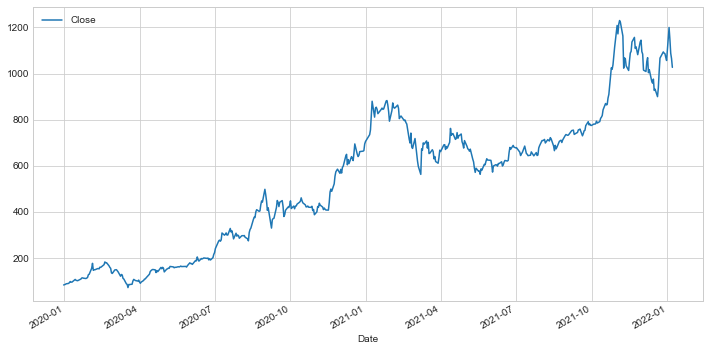

In [57]:
stock_data = stock_data[['Close']]

fig, ax = plt.subplots(figsize=(12, 6))
stock_data.plot(ax = ax)

In [58]:
from sklearn.model_selection import train_test_split
stock_data_train, stock_data_test = train_test_split(stock_data, test_size=0.1, shuffle=False)

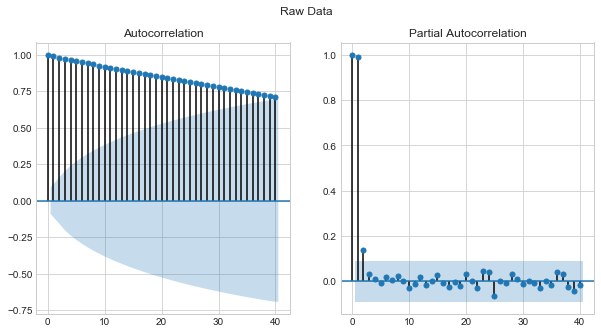

In [59]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(stock_data_train.values.squeeze(), lags=40, ax=ax[1]); # Modify not to generate graph twice

In [60]:
diff_stock_data_train = stock_data_train.copy()
diff_stock_data_train = diff_stock_data_train['Close'].diff()
diff_stock_data_train = diff_stock_data_train.dropna()
print('####### Raw Data #######')
print(stock_data_train)
print('### Differenced Data ###')
print(diff_stock_data_train)

####### Raw Data #######
                  Close
Date                   
2019-12-31    83.666000
2020-01-02    86.052002
2020-01-03    88.601997
2020-01-06    90.307999
2020-01-07    93.811996
...                 ...
2021-10-19   864.270020
2021-10-20   865.799988
2021-10-21   894.000000
2021-10-22   909.679993
2021-10-25  1024.859985

[459 rows x 1 columns]
### Differenced Data ###
Date
2020-01-02      2.386002
2020-01-03      2.549995
2020-01-06      1.706001
2020-01-07      3.503998
2020-01-08      4.616005
                 ...    
2021-10-19     -5.839966
2021-10-20      1.529968
2021-10-21     28.200012
2021-10-22     15.679993
2021-10-25    115.179993
Name: Close, Length: 458, dtype: float64


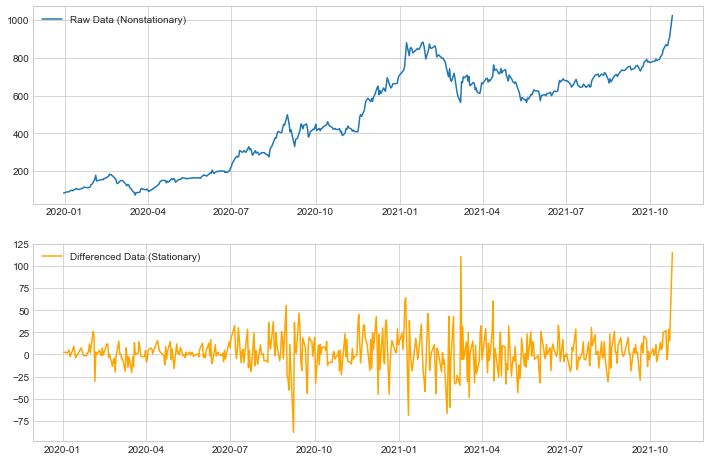

In [61]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(stock_data_train['Close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_stock_data_train,'orange') # first difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

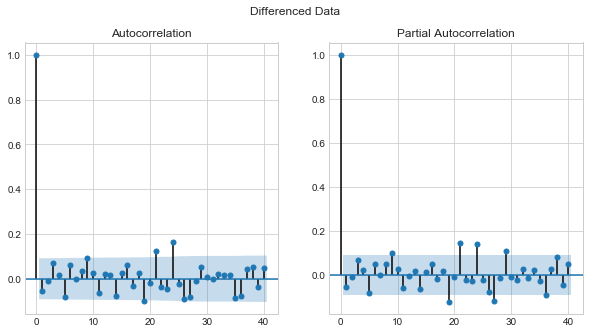

In [62]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_stock_data_train.values.squeeze(), lags=40, ax=ax[1]); # Modify not to generate graph twice

In [63]:
# Parameter search 

auto_arima_model = auto_arima(stock_data_train, start_p=1, start_q=1,
                              max_p=3, max_q=3, seasonal=False,
                              d=1,
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4035.671, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4036.100, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4038.100, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4037.965, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4036.120, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4038.100, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4039.952, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4039.961, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4038.050, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4039.778, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4040.399, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4037.867, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4039.779, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4040.454, Time=0.50 sec

Best model:  A

In [64]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  459
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2015.835
Date:                Wed, 12 Jan 2022   AIC                           4035.671
Time:                        20:36:24   BIC                           4043.924
Sample:                             0   HQIC                          4038.921
                                - 459                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.0550      0.934      2.199      0.028       0.223       3.887
sigma2       389.5129     13.431     29.002      0.000     363.189     415.837
===================================================================================
Ljung-Box (Q):                       68.80   Jarque-Bera (JB):               601.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.81   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
AUTO_ARIMA_prediction = auto_arima_model.predict(len(stock_data_test), return_conf_int=True)
AUTO_ARIMA_test_pred = AUTO_ARIMA_prediction[0]
AUTO_ARIMA_test_ub = AUTO_ARIMA_prediction[1][:,0]
AUTO_ARIMA_test_lb = AUTO_ARIMA_prediction[1][:,1]
predict_index = list(stock_data_test.index)
predict_index[0]

Timestamp('2021-10-26 00:00:00')

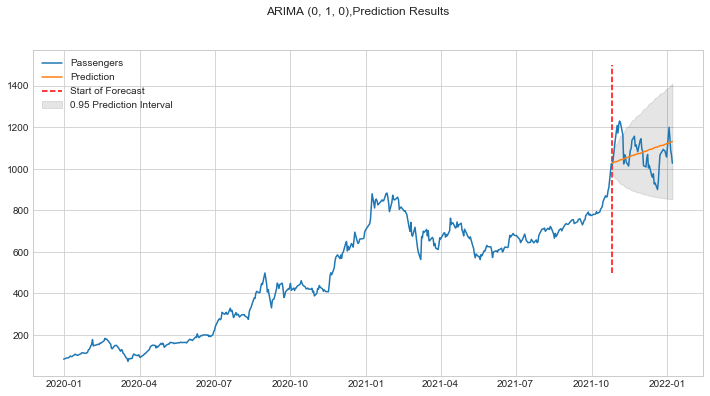

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(stock_data.index, stock_data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('2021-10-26','%Y-%m-%d'), 500, 1500, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, AUTO_ARIMA_test_pred, label = 'Prediction')
ax.fill_between(predict_index, AUTO_ARIMA_test_lb, AUTO_ARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order},Prediction Results')
plt.show()

In [67]:
stock_data_train_prophet = stock_data_train.reset_index()
stock_data_train_prophet.columns = ['ds', 'y']

PRO_model = Prophet()
PRO_model.fit(stock_data_train_prophet)

stock_data_test_prophet = stock_data_test.reset_index()
stock_data_test_prophet.columns = ['ds', 'y']
stock_data_test_index = stock_data_test_prophet[['ds']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [68]:
PRO_prediction = PRO_model.predict(stock_data_test_index)
PRO_prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-10-26,824.346454,769.139193,881.312271,824.346454,824.346454,3.109761,3.109761,3.109761,3.109761,3.109761,3.109761,0.0,0.0,0.0,827.456215
1,2021-10-27,825.930347,772.456868,884.654382,825.930347,825.930347,2.628524,2.628524,2.628524,2.628524,2.628524,2.628524,0.0,0.0,0.0,828.558871
2,2021-10-28,827.514240,773.836106,883.689571,827.514240,827.514240,2.340383,2.340383,2.340383,2.340383,2.340383,2.340383,0.0,0.0,0.0,829.854623
3,2021-10-29,829.098133,778.199161,888.075451,829.098133,829.098133,2.705241,2.705241,2.705241,2.705241,2.705241,2.705241,0.0,0.0,0.0,831.803374
4,2021-11-01,833.849812,780.155882,895.530250,833.798968,833.882703,3.426257,3.426257,3.426257,3.426257,3.426257,3.426257,0.0,0.0,0.0,837.276069
5,2021-11-02,835.433705,776.209271,898.581382,835.213306,835.618337,3.109761,3.109761,3.109761,3.109761,3.109761,3.109761,0.0,0.0,0.0,838.543466
6,2021-11-03,837.017598,784.416338,896.399260,836.627906,837.433172,2.628524,2.628524,2.628524,2.628524,2.628524,2.628524,0.0,0.0,0.0,839.646122
7,2021-11-04,838.601491,786.700539,897.087536,837.928437,839.310864,2.340383,2.340383,2.340383,2.340383,2.340383,2.340383,0.0,0.0,0.0,840.941874
8,2021-11-05,840.185384,788.145614,897.859484,839.243088,841.215585,2.705241,2.705241,2.705241,2.705241,2.705241,2.705241,0.0,0.0,0.0,842.890625
9,2021-11-08,844.937063,793.095758,904.433591,843.000269,847.010928,3.426257,3.426257,3.426257,3.426257,3.426257,3.426257,0.0,0.0,0.0,848.363320


In [69]:
PRO_test_pred = PRO_prediction['yhat'].values
PRO_test_ub = PRO_prediction['yhat_upper'].values
PRO_test_lb = PRO_prediction['yhat_lower'].values
predict_index = list(stock_data_test.index)

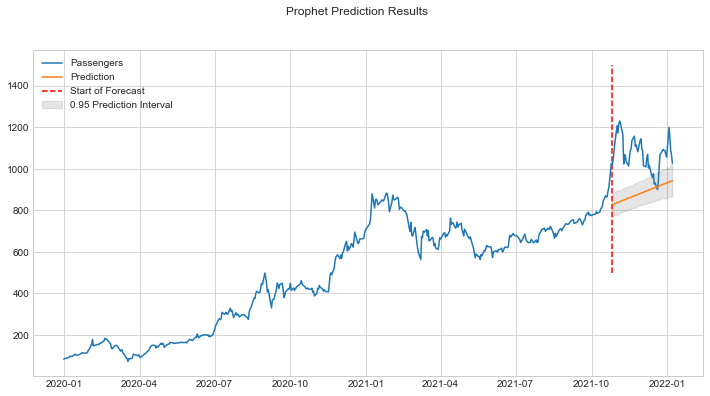

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(stock_data.index, stock_data.values, label = 'Passengers')
ax.vlines(datetime.datetime.strptime('2021-10-26','%Y-%m-%d'), 500, 1500, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, PRO_test_pred, label = 'Prediction')
ax.fill_between(predict_index, PRO_test_lb, PRO_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle('Prophet Prediction Results')
plt.show()

# EOD